In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../Data/final_ratings.csv")

In [3]:
df.head()

,Unnamed: 0,userId,movieId,rating,y,n_ratings
0,0,1,2,3.5,-0.2,22243
1,1,5,2,3.0,-0.7,22243
2,2,13,2,3.0,-0.7,22243
3,3,29,2,3.0,-0.7,22243
4,4,34,2,3.0,-0.7,22243


In [4]:
from tensorflow import keras
import tensorflow as tf

In [5]:
user_input = keras.Input(shape = (1,), name = "user_id")
movie_input = keras.Input(shape = (1,), name = "movie_id")
Embedd_user = keras.layers.Embedding(df.userId.max()+10,30, name="Embedd_user")(user_input)
Embedd_movies = keras.layers.Embedding(df.movieId.max()+10,30, name="Embedd_movies")(movie_input)
Dot = keras.layers.Dot(2)([Embedd_user,Embedd_movies])
Flatten = keras.layers.Flatten()(Dot)

model = keras.Model(
    inputs = [user_input, movie_input],
    outputs = Flatten
)

model.compile(
    tf.optimizers.Adam(0.005),
    loss='MSE',
    metrics=['MAE'],
)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embedd_user (Embedding)         (None, 1, 30)        4155090     user_id[0][0]                    
__________________________________________________________________________________________________
Embedd_movies (Embedding)       (None, 1, 30)        3938160     movie_id[0][0]                   
______________________________________________________________________________________________

In [7]:
from sklearn.model_selection import train_test_split
u_train, u_test, m_train, m_test, r_train, r_test = train_test_split(df.userId, df.movieId, df.rating,
                                                                     test_size= 0.005,
                                                                    random_state = 875)

In [8]:
m_train.min()

1

In [9]:
model.fit(x = [u_train, m_train], y = r_train, epochs= 40, batch_size= 800000, validation_data=([u_test, m_test], r_test))

Train on 19900261 samples, validate on 100002 samples
Epoch 1/40
19900261/19900261 [==============================] - 7s 0us/sample - loss: 13.4215 - MAE: 3.5093 - val_loss: 12.8409 - val_MAE: 3.4275
Epoch 2/40
19900261/19900261 [==============================] - 7s 0us/sample - loss: 10.1314 - MAE: 2.9864 - val_loss: 6.0097 - val_MAE: 2.2368
Epoch 3/40
19900261/19900261 [==============================] - 7s 0us/sample - loss: 2.8703 - MAE: 1.4015 - val_loss: 1.1466 - val_MAE: 0.8355
Epoch 4/40
19900261/19900261 [==============================] - 7s 0us/sample - loss: 0.9521 - MAE: 0.7505 - val_loss: 0.8020 - val_MAE: 0.6883
Epoch 5/40
19900261/19900261 [==============================] - 7s 0us/sample - loss: 0.7724 - MAE: 0.6780 - val_loss: 0.7526 - val_MAE: 0.6671
Epoch 6/40
19900261/19900261 [==============================] - 7s 0us/sample - loss: 0.7453 - MAE: 0.6626 - val_loss: 0.7426 - val_MAE: 0.6610
Epoch 7/40
19900261/19900261 [==============================] - 7s 0us/sample -

In [10]:
%%time
train_result = model.predict([u_train, m_train], batch_size= 800000).reshape(-1) - r_train
train_mean=abs(train_result).mean()
train_std = train_result.std()


test_result = model.predict([u_test, m_test], batch_size= 800000).reshape(-1) - r_test
test_mean = abs(test_result).mean()
test_std = test_result.std()



CPU times: user 8.43 s, sys: 2.39 s, total: 10.8 s
Wall time: 3.07 s


In [11]:
result = f"""結果出來了，訓練結果：
訓練資料 abs(loss).mean() = {train_mean} 標準差 = {str(train_std)}
測試資料 abs(loss).mean() = {str(test_mean)} 標準差 = {str(test_std)}"""
print(result)

結果出來了，訓練結果：
訓練資料 abs(loss).mean() = 0.5525054354229684 標準差 = 0.7234922604390132
測試資料 abs(loss).mean() = 0.5971942899042904 標準差 = 0.7845180634641342


In [12]:
model.save("0109_Embedding_user_movie_30.h5")

In [13]:
test_result

2654046     0.475652
9333374    -0.757320
12636627   -0.553151
12371374    0.573857
16601336    0.411088
              ...   
11123693    0.152482
10045515   -0.294551
5202555     0.042824
2274953    -1.185220
4241757     0.200929
Name: rating, Length: 100002, dtype: float64

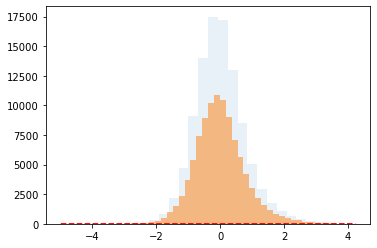

In [14]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab  
plt.hist(test_result, bins= 30, alpha=0.1)
num_bins = 50 
n, bins, patches = plt.hist(test_result, num_bins, alpha=0.5)  


from scipy.stats import norm
y=norm.pdf(bins, test_result.mean(), test_result.std())


plt.plot(bins, y, 'r--')  


plt.subplots_adjust(left=0.15)  
plt.show()

可以看到，結果在以零為中心點，呈現常態分佈

顯示此模型是有效的

In [15]:
import numpy as np
movieId = np.array(range(1, 100000)).reshape(-1)
userId = np.array([2] * len(movieId)).reshape(-1)
result = model.predict((userId, movieId), batch_size=100000)

In [16]:
result_df = pd.DataFrame()

In [17]:
movie_df = pd.read_csv("../Data/final_movies.csv")

In [18]:
movie_id_title_mapping = {}
for _, row in movie_df.iterrows():
    movie_id_title_mapping[row["movieId"]] = row["title"]

In [19]:
result_df["user"] = userId
result_df["movieId"] = movieId
result_df["title"] = result_df["movieId"].apply(lambda x: movie_id_title_mapping.setdefault(x))
result_df["predict"] = result

In [20]:
result_df.sort_values("predict", ascending=False).head(20)

,user,movieId,title,predict
79841,2,79842,For Neda,5.941921
73364,2,73365,Dead Time: Kala,5.747890
98274,2,98275,"Octopus, The (Le poulpe)",5.684314
88569,2,88570,Welfare,5.642259
77735,2,77736,Crazy Stone (Fengkuang de shitou),5.631209
56778,2,56779,I Don't Want to Sleep Alone (Hei yan quan),5.613787
94805,2,94806,The Secrets of Jonathan Sperry,5.590261
85011,2,85012,"Given Word, The (O Pagador de Promessas)",5.567002
56868,2,56869,Drained (O cheiro do Ralo),5.562891
57647,2,57648,The Green Man,5.536143
